In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/vision/use-cases/advertisment-creation-using-gemini-and-imagen3/advertisment-creation-using-gemini-and-imagen3.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/vision/use-cases/advertisment-creation-using-gemini-and-imagen3/advertisment-creation-using-gemini-and-imagen3.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/vision/use-cases/advertisment-creation-using-gemini-and-imagen3/advertisment-creation-using-gemini-and-imagen3.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/vision/use-cases/advertisment-creation-using-gemini-and-imagen3/advertisment-creation-using-gemini-and-imagen3.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

</t> |Author(s) | [Ankul Jain](https://github.com/ankuljain09) , [Koyel Guha](https://github.com/koyelguha)


---



# Generating Advertising Images using Gemini and  Imagen 3


# Overview
To create advertising materials in the marketing department of any company is a time consuming process. Additionally, it is a time consuming process to respond to the individual customization of materials from the sales department, as it requires output within a short period of time (creating images with ad texts and text placement in mind).
This notebook effectively combines the strengths of Imagen3 for image generation and Gemini for text creation, with Python acting as the bridge to integrate and finalize the advertisement.

1.   **Image Generation with Imagen**: A detailed prompt is used to generate multiple image options using Imagen3. The best image is selected.
2.   **Ad Text Creation with Gemini**: A prompt is used to generate multiple ad copy options using Gemini. The best ad copy is selected.
3.   **Image and Text Integration using Python**: The chosen image and ad copy are combined using Python code, The position and style of the text are customized.
4.   **Finalizing and Saving**:  Review the final image and download.


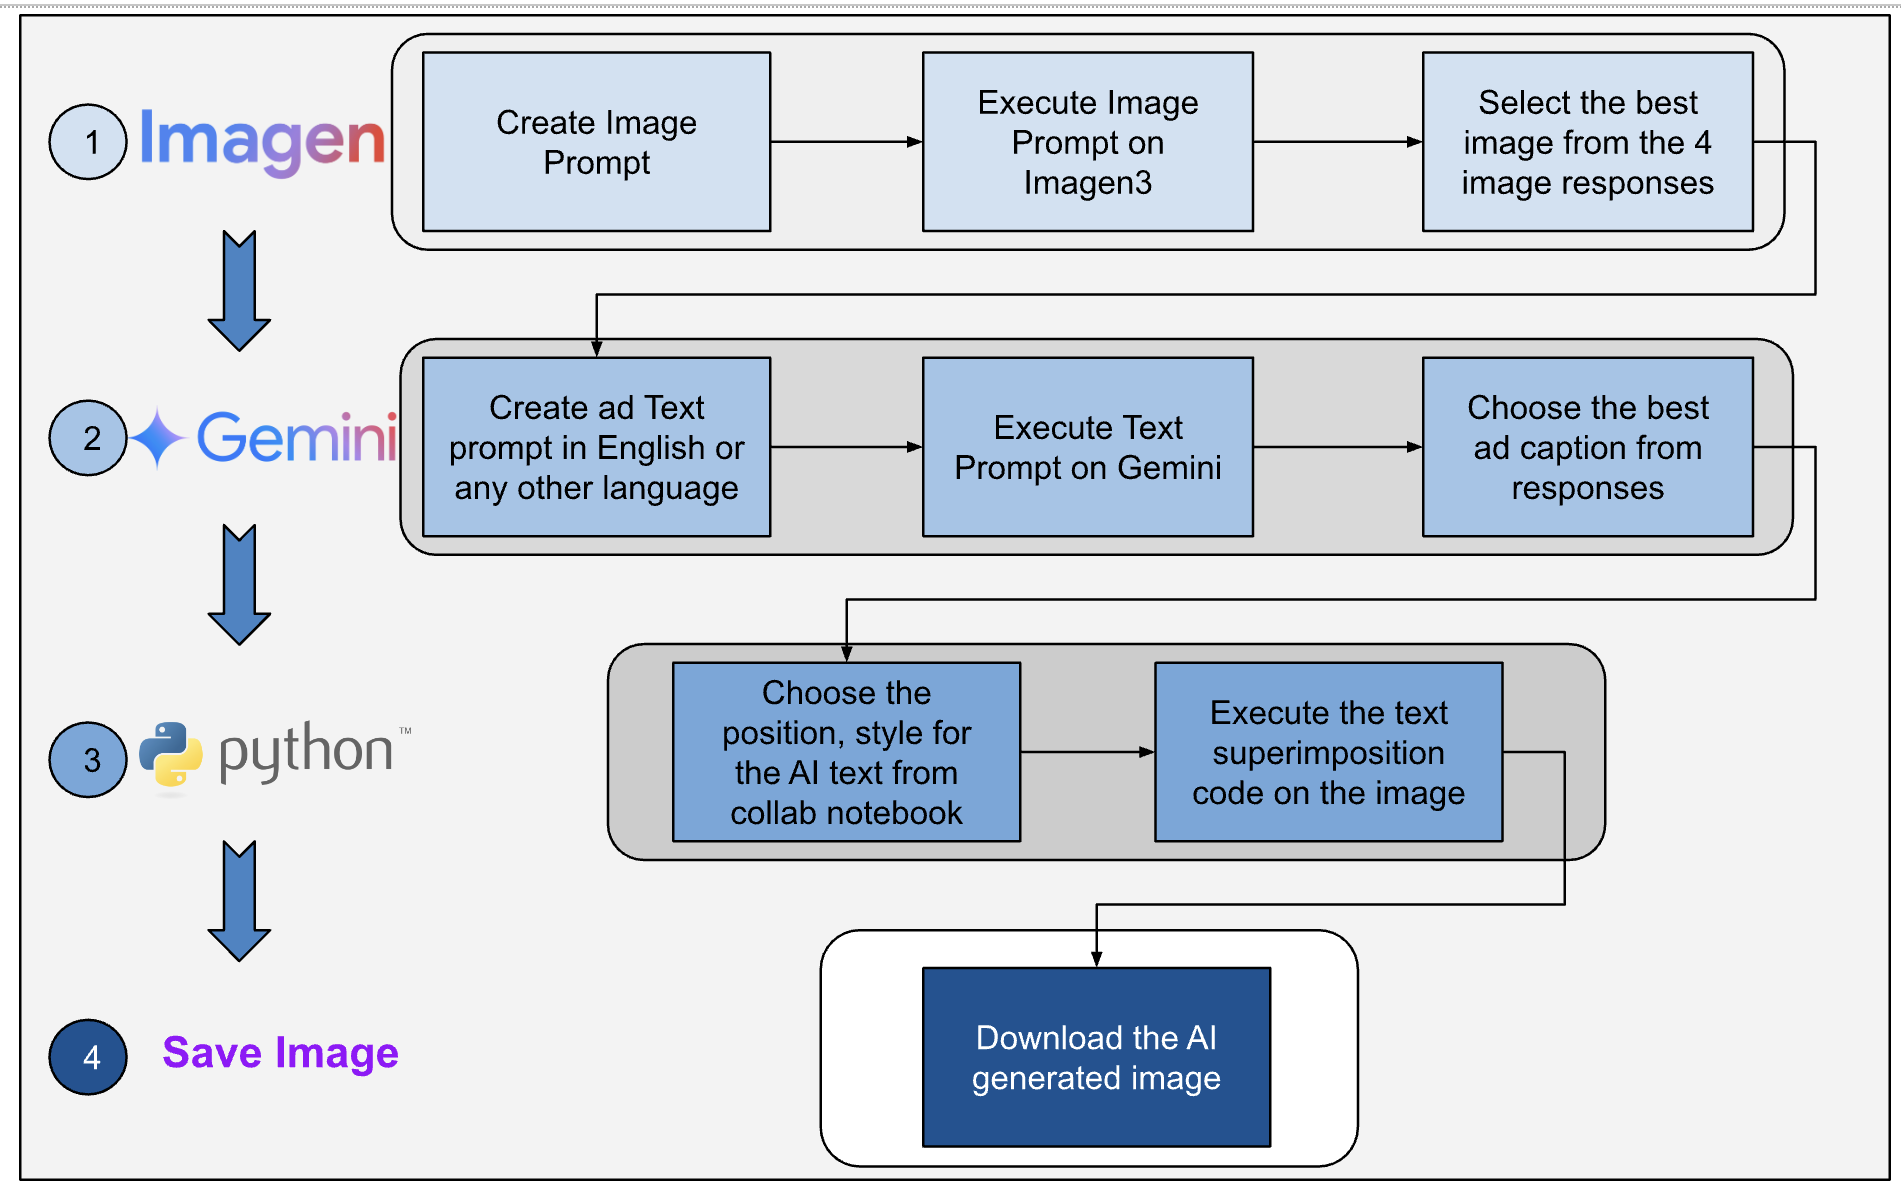

# Get Started

## Install Vertex AI SDK and other required packages

In [ ]:
%pip install --upgrade --user -q google-cloud-aiplatform rembg Pillow opencv-python numpy requests gradio matplotlib

##Restart runtime
To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [2]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

## Authenticate your notebook environment (Colab only)
If you're running this notebook on Google Colab, run the cell below to authenticate your environment.

In [1]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

## Set Google Cloud project information and initialize Vertex AI SDK
To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). <br>

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [1]:

# Use the environment variable if the user doesn't provide Project ID.
import os

import vertexai

PROJECT_ID = "your-project-id"  # @param {type: "string", placeholder: "[your-project-id]", isTemplate: true}
if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

vertexai.init(project=PROJECT_ID, location=LOCATION)

## Import Required Libraries

In [3]:
from enum import Enum
import random
import time
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
import gradio as gr

## Load Model

In [4]:
from vertexai.preview.vision_models import ImageGenerationModel
imagen_model = ImageGenerationModel.from_pretrained("imagen-3.0-generate-001")

from vertexai.preview.generative_models import GenerativeModel
gemini_flash_model = GenerativeModel("gemini-1.5-flash-002")

## Generate Images using Imagen3
The images are genrated using google vertexai SDK that works on ImageGenerationModel module.


*   The Imagen model requires a prompt to generate the image
*   A negative prompt can be provided additionally, if required
*   Aspect Ratio - 16:9
*   Seed - Same value for consistent responses


For more details refer to the Imagen3 documentation [here](https://cloud.google.com/vertex-ai/generative-ai/docs/image/generate-images#text-image-gen)

In [5]:
# Generate image using Imagen3
def imagen_generate_sdk(
    model_name: str,
    prompt: str,
    negativePrompt: str,
    sampleCount: int,
    seed: int | None = None,
    disablePersonFace: bool | None = False,
    sampleImageStyle: str | None = None,
) -> list[Image.Image]:
    response = model_name.generate_images(
        prompt=prompt,
        number_of_images=sampleCount,
        negative_prompt=negativePrompt,
        aspect_ratio="16:9",
        seed=seed,
        add_watermark=False
    )

    pillow_images = []
    for image in response.images:
        pillow_images.append(image._pil_image)
    return pillow_images


# Display Images as an array of images in PIL image format
def display_images(pil_images):
    scale = 1
    sampleImageSize = 100
    width = int(float(sampleImageSize) * scale)
    height = int(float(sampleImageSize) * scale)
    for index, result in enumerate(pil_images):
        width, height = pil_images[index].size
        print(index)
        display.display(
            pil_images[index].resize(
                (
                    int(pil_images[index].size[0] * scale),
                    int(pil_images[index].size[1] * scale),
                ),
                0,
            )
        )
        print()

## Generate advertisment text using Gemini

In [6]:
# Generate ad text using gemini 1.5 flash model
def generate_ad_text(text_prompt):
    responses = gemini_flash_model.generate_content(
        text_prompt
    )

    return responses.text

text_prompt = """Create a catchy advertisement tagline featuring the comparative strengths of Cymbal\'s internet service that sets them apart from the competition. Keep the tagline within 50 characters.
"""

generated_text = generate_ad_text(text_prompt).replace("\n", "")
print((generated_text))

Cymbal:  Faster. Stronger.  Simpler.


## Add text overaly on the generated images

In [7]:
# Superimpose the AI geenrated text on AI generated image
def superimpose_text_on_image(base_image, text_sections, position, font_size=100
                              , text_color=(255, 255, 255), font_path = "./GoogleSans-Bold.ttf"):
    # Create a draw object
    draw = ImageDraw.Draw(base_image)

    font = ImageFont.truetype(font_path, font_size)

    # Starting position based on the specified position
    if position == "TOP_LEFT":
        x = 0
        y = 0
    elif position == "TOP_CENTER":
        x = (base_image.width // 2)
        y = 0
    elif position == "TOP_RIGHT":
        x = base_image.width
        y = 0
    elif position == "CENTER":
        x = (base_image.width // 2)
        y = (base_image.height // 2) - (font_size * len(text_sections) // 2)  # Center vertically
    elif position == "BOTTOM_LEFT":
        x = 0
        y = base_image.height - font_size * len(text_sections)
    elif position == "BOTTOM_CENTER":
        x = (base_image.width // 2)
        y = base_image.height - font_size * len(text_sections)
    elif position == "BOTTOM_RIGHT":
        x = base_image.width
        y = base_image.height - font_size * len(text_sections)
    elif position == "MIDDLE_LEFT":
        x = 0
        y = (base_image.height // 2) - (font_size * len(text_sections) // 2)  # Center vertically
    elif position == "MIDDLE_CENTER":
        x = (base_image.width // 2)
        y = (base_image.height // 2) - (font_size * len(text_sections) // 2)  # Center vertically
    elif position == "MIDDLE_RIGHT":
        x = base_image.width
        y = (base_image.height // 2) - (font_size * len(text_sections) // 2)  # Center vertically

    # Draw each section of the text
    for i, text in enumerate(text_sections):
        # Adjust x for center positioning
        if position in ["TOP_CENTER", "CENTER", "BOTTOM_CENTER", "MIDDLE_CENTER"]:
            text_width = draw.textlength(text, font=font)
            x = (base_image.width - text_width) // 2  # Center the text horizontally
        elif position in ["MIDDLE_LEFT", "MIDDLE_RIGHT"]:
            text_width = draw.textlength(text, font=font)
            if position == "MIDDLE_RIGHT":
                x = base_image.width - text_width  # Right align text

        draw.text((x, y), text.strip(), fill=text_color, font=font)
        y += font_size  # Move y position down for the next line of text

    return base_image

# Function to resize image to 16:9 aspect ratio
def resize_to_aspect_ratio(image):
    width, height = image.size
    new_height = int(width * (9 / 16))
    if new_height > height:
        new_width = int(height * (16 / 9))
        new_height = height
    else:
        new_width = width

    return image.resize((new_width, new_height), Image.LANCZOS)

# Function to clear text from images
def clear_text_from_images(images):
    return images  # Return the original images

## Styling the Adverstisement Image



*   Specify where do you want to superimpose the text on the image.
*   Provide font file to be used
*   Provide logo to be inserted on the image



In [8]:
class Position(Enum):
    TOP_RIGHT = "TOP_RIGHT"
    TOP_CENTER = "TOP_CENTER"
    TOP_LEFT = "TOP_LEFT"
    MIDDLE_RIGHT = "MIDDLE_RIGHT"
    CENTER = "CENTER"
    MIDDLE_CENTER = "MIDDLE_CENTER"
    MIDDLE_LEFT = "MIDDLE_LEFT"
    BOTTOM_RIGHT = "BOTTOM_RIGHT"
    BOTTOM_CENTER = "BOTTOM_CENTER"
    BOTTOM_LEFT = "BOTTOM_LEFT"


In [14]:
# Function to create advertisment
def call_ad_maker(
    prompt, negative_prompt, sample_resultcount=4, seed=101
):
    IMAGE_MODEL_NAME = imagen_model
    sampleCount = int(sample_resultcount)
    negativePrompt = "any other branded images, laptops, mobiles, animals, food, large objects"

    # Advanced option, try different seed numbers which can be a random integer number under range: (0, 2147483647)
    sampleImageStyle = None

    images = imagen_generate_sdk(
        IMAGE_MODEL_NAME,
        prompt,
        negativePrompt,
        sampleCount,
        seed,
        False,
        sampleImageStyle,
    )

    # Get the current timestamp and a random number
    current_timestamp = int(time.time())
    random_number = random.randint(1000, 9999)
    unique_number = int(str(current_timestamp) + str(random_number))
    # Concatenate timestamp and random number to create a unique number
    directory_path = "results/" + str(unique_number)
    if not os.path.exists(directory_path):
        # Create the directory
        os.makedirs(directory_path)

    results = []
    for bg_image in images:
        img_resized = resize_to_aspect_ratio(bg_image)
        results.append(img_resized)
    return results

## Sample Run with Superimposing Gemini Generated advertisment text on Imagen3 geenrated images

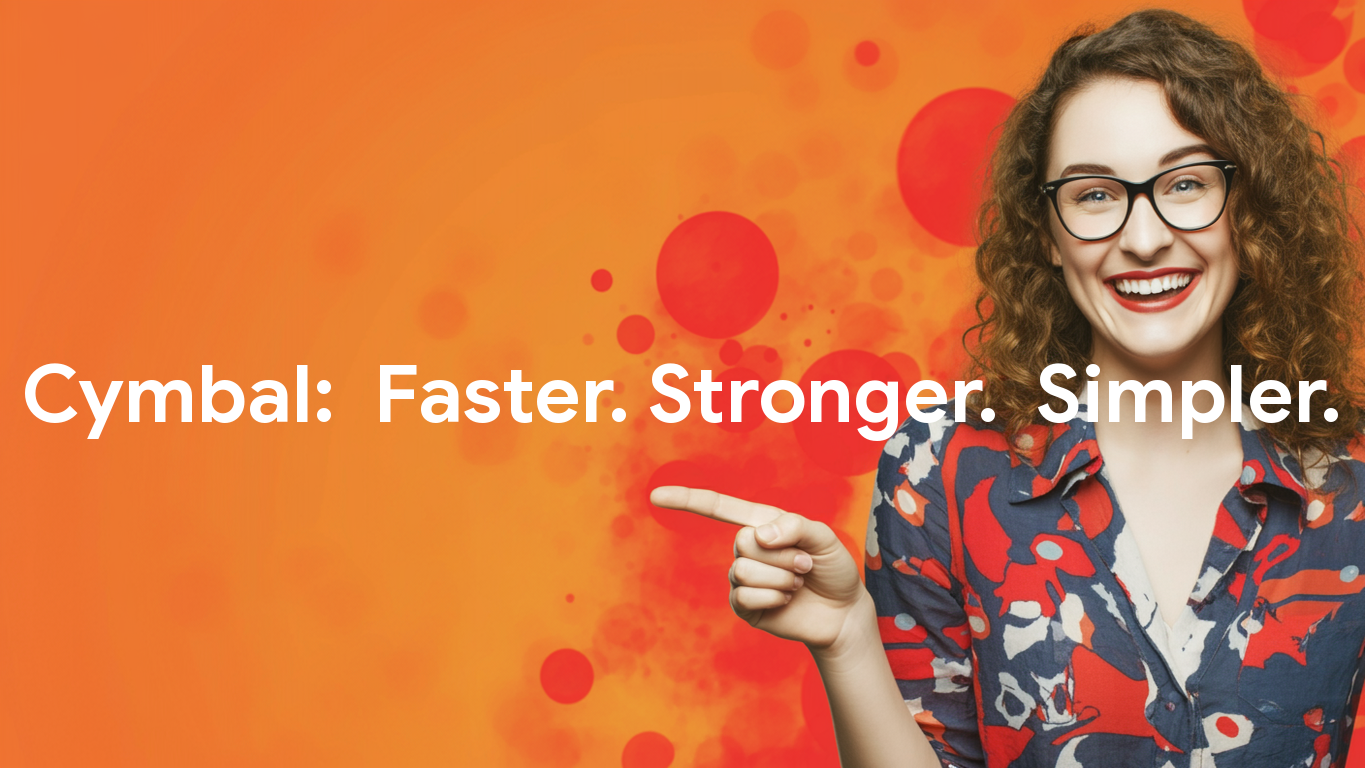

In [16]:
sample_resultcount = 1
results = call_ad_maker(
    "An English woman on the right side of the image, smiling broadly, pointing towards left . The background of the lady is orange color scheme with faded red bubbles. The majority of the background on left side is empty. Style: Modern, advertising, minimalist.",
    "brands",
    sample_resultcount,
    100
)

for res in results:
    img_with_text = superimpose_text_on_image(res, [generated_text], Position.CENTER.value, 80)
    display(img_with_text)

## Gradio UI for generating advertisment images with few clicks

In [ ]:
current_text = generated_text  # Variable to store the current text
# Initialize a variable to keep track of original images
original_images = []



# List of sample prompts and placeholder images
sample_data = [
    {
        "prompt": "An English woman on the right side of the image, smiling broadly, pointing towards left . The background of the lady is orange color scheme with faded bubbles. The majority of the background on left side is empty. Style: Modern, advertising, minimalist.",
        "image": "./sample_gemini_imagen_adImage_1.png"  # Placeholder paths for your reference images
    },
    {
        "prompt": "A  handsome Japanese Man on the right side of the image, smiling gently, pointing towards left . The background of the man is blue color scheme with faded geometric  patterns. The majority of the background on left side is empty. Style: Modern, advertising, minimalist.",
        "image": "./sample_gemini_imagen_adImage_2.png"
    }
]



# Gradio interface components
image_choices = [data["image"] for data in sample_data]
prompts = [data["prompt"] for data in sample_data]

# Gradio interface setup
with gr.Blocks() as demo:

    with gr.Row():
        with gr.Column(min_width=100):
            selected_image = gr.Dropdown(choices=image_choices, label="Select a Reference Image")
            selected_prompt = gr.Textbox(label="Prompt", interactive=False)

            ref_image_display = gr.Image(label="Reference Image", type="pil")


            # Update reference image and prompt when an image is selected
            def update_ref_image_and_prompt(image_name):
                img = Image.open(image_name)
                img_resized = resize_to_aspect_ratio(img)  # Resize to 16:9 aspect ratio
                return img_resized

            selected_image.change(fn=update_ref_image_and_prompt, inputs=selected_image, outputs=[ref_image_display])

            # Load initial prompt when an image is selected
            def update_prompt(image_name):
                idx = image_choices.index(image_name)
                return prompts[idx]

            selected_image.change(fn=update_prompt, inputs=selected_image, outputs=selected_prompt)

            with gr.Row():
                with gr.Column(min_width=100):
                    background_context = gr.Textbox(
                        label="Enter your prompt for image background"
                    )
                    negative_prompt = gr.Textbox(
                        label="Anything you want to avoid seeing in the image? eg: forest, plants, car"
                    )

                    sample_resultcount = gr.Textbox(
                        label="How many images you want to see? 1-4"
                    )
                    seed_value = gr.Slider(minimum=10, maximum=200, label="Enter Seed", randomize=True)


            with gr.Row():
                with gr.Row():
                    with gr.Column(min_width=50):
                        generate_btn = gr.Button("Generate")
                    with gr.Column(min_width=50):
                        clear = gr.ClearButton()
    with gr.Row():
        with gr.Column():
            with gr.Column():
                with gr.Row():
                    bg_gallery = gr.Gallery()

    def on_click(
        background_context,
        negative_prompt,
        sample_resultcount,
        seed_value
    ):
        global original_images  # Access the global variable
        original_images = call_ad_maker(
            prompt=background_context,
            negative_prompt=negative_prompt,
            sample_resultcount=sample_resultcount,
            seed=int(seed_value),

        )

        return gr.Gallery(original_images)

    generate_btn.click(
        fn=on_click,
        inputs=[
            background_context,
            negative_prompt,
            sample_resultcount,
            seed_value
        ],
        outputs=[bg_gallery],
    )
    # New section for superimposing text after image generation
    with gr.Row():
        # User Text input (allow to modify or add custom text)
        text_sections = gr.Textbox(label="Gemini Generated Text (Put comma-separated text for multiline effect)", placeholder="Enter text to superimpose", value=generated_text)

        position_dropdown = gr.Dropdown(label="Text Position", choices=[p.value for p in Position], value=Position.BOTTOM_LEFT.value)
        font_size_input = gr.Slider(minimum=10, maximum=200, label="Enter Font Size", randomize=True)
        apply_text_btn = gr.Button("Apply Text")
        clear_text_btn = gr.Button("Clear Text")  # Button to clear text


        def apply_text_to_images(images, text, position, font_size_input):
            processed_images = []
            text_sections = text.split(",")  # Split by comma to get sections
            for img in images:
                if isinstance(img, tuple):  # Check if img is a tuple
                    img_path = img[0]  # Extract the image path from the tuple
                else:
                    img_path = img  # If it's not a tuple, use it directly
                img = Image.open(img_path)
                img_with_text = superimpose_text_on_image(img, text_sections, position, font_size_input)
                img_with_text = resize_to_aspect_ratio(img_with_text)  # Resize to 16:9 aspect ratio
                processed_images.append(img_with_text)
            return processed_images

        def clear_text(images):
          global current_text
          current_text = ""  # Clear the current text
          return original_images  # Return images without text applied


        apply_text_btn.click(
            fn=apply_text_to_images,
            inputs=[bg_gallery, text_sections, position_dropdown, font_size_input],
            outputs=bg_gallery,)

        clear_text_btn.click(
            fn=clear_text,
            inputs=[bg_gallery],  # Input the current images
            outputs=bg_gallery,)




# Launch the Gradio app
demo.launch(debug=True, share=True)

# Conclusion

This notebook demonstrates the power of combining Google Cloud's Generative AI tools, Imagen3 and Gemini, to create a seamless and dynamic advertising workflow. By integrating these cutting-edge technologies with a user-friendly interface, we've shown how we can efficiently generate and deploy captivating ad creatives. This opens up exciting possibilities for streamlining the advertising pipeline and unlocking new levels of creativity.